In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import argparse
import os
import glob
import sys


In [29]:
def preprocess(image, RESIZE = False):
    """
    Function for preprocessing our image

    input: 
        np.array, image 

    output:
        res: np.array, preprocessed image
    """
    
    #look at number of channels
    _,_,nc = image.shape

    if nc >1:
        # Change color code from BGR to HSV
        res = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    else:
        # if the image is grayscale we duplicate it to 3 channels
        res = np.stack((image, image, image), axis = 2)

    # res = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Preprocessing steps to be added
    
    if RESIZE:
        target_width = 256
        target_height = 256
        res = cv2.resize(res, (target_width, target_height))

    return res

In [4]:
def histogram(query):
    """
    Input:
        query: np.array, query image 
    Output:
        res: np.array, one-dimensional vector with all the histograms merged into one

    """
    h_bins = np.int16(np.dot([1, 26, 41, 121, 191, 271, 295, 316, 361], 0.5))
    s_bins = np.int16(np.dot([0, 0.2, 0.7, 1], 255))
    v_bins = np.int16(np.dot([0, 0.2, 0.7, 1], 255))

    h_hist, _ = np.histogram(query[:,:,0].ravel(), bins = h_bins)
    s_hist, _ =  np.histogram(query[:,:,1].ravel(), bins = s_bins)
    v_hist, _ = np.histogram(query[:,:,2].ravel(), bins = v_bins)

    #normalising our histogram
    h_hist = np.dot(h_hist, 1/np.sum(h_hist))
    s_hist = np.dot(s_hist, 1/np.sum(s_hist))
    v_hist = np.dot(v_hist, 1/np.sum(v_hist))


    res =  np.array(h_hist.tolist() +  s_hist.tolist() + v_hist.tolist())


    return res


In [31]:
def compute_database_hists(database, method):
    data = os.listdir(database)


    # this is to get the size of the descriptor of our method. We compute the descriptor of the first image

    first_image = data[0]
    first_image = cv2.imread(os.path.join(database, first_image))
    if method.__name__ == 'block_histogram':
        first_image = preprocess(first_image, RESIZE = False)
    elif method.__name__ == 'histogram':
        first_image = preprocess(first_image, RESIZE = False)
    elif method.__name__ == 'weighted_block_histogram':
        first_image = preprocess(first_image, RESIZE = True)
        
    first_image_hist = method(first_image)
    database_hists = np.empty((tuple([len(data)]) + first_image_hist.shape)) 

    database_hists[0] = first_image_hist

    for i, x in enumerate(data[1:]):
        x = os.path.join(database, x)
        target_im = cv2.imread(x) # read image

        #preprocess image
        if method.__name__ == 'block_histogram':
            target_im = preprocess(target_im, RESIZE = False)
        elif method.__name__ == 'histogram':
            target_im = preprocess(target_im, RESIZE = False)
        elif method.__name__ == 'weighted_block_histogram':
            target_im = preprocess(target_im, RESIZE = True)
        #compute histogram with given method
        target_hist = method(target_im)

        #store result
        database_hists[i+1] = target_hist

    return database_hists


In [6]:
def block_histogram(query):
    """
    This function divides the query image into blocks and computes histograms on these blocks. 
    This implementation is based on paper "Content-based image retrieval using color and texture fused features"
    https://www.sciencedirect.com/science/article/pii/S0895717710005352

    Input:
        query: np.array, image

    output:
        res: np.array. If we split our image in N blocks, dimension will be Number of Hist bins * N
    """
    h,w, _ = np.shape(query)
    
    n_blocks = (3,3)
    height_indices = [k * int(h/n_blocks[0]) for k in range(n_blocks[0] + 1)]
    width_indices = [k * int(w/n_blocks[1]) for k in range(n_blocks[1] + 1)]
    res = np.zeros((n_blocks[0]*n_blocks[1], 14))
    cnt = 0

    for i in range(n_blocks[0]):
        for j in range (n_blocks[1]):
            # divide image into blocks
            block = query[height_indices[i]: height_indices[i+1], width_indices[j]: width_indices[j+1]]
            hist = histogram(block)
            res[cnt] = hist
            cnt += 1

    return res

In [7]:
def weighted_block_histogram(query):
    h,w, _ = np.shape(query)
    height_indices = [0, int(h/4), int(3*h/4), h]
    width_indices = [0, int(w/4), int(3*w/4), w]
    res = np.zeros((9, 14))
    cnt = 0
    for i in range(3):
        for j in range (3):
            # divide image into blocks
            block = query[height_indices[i]: height_indices[i+1], width_indices[j]: width_indices[j+1]]
            hist = histogram(block)
            res[cnt] = hist
            cnt += 1

    return res

In [8]:
def compute_scores(data_path, image, best_results):
    database = os.listdir(os.path.join(data_path, 'database'))

    image_object = image.split('_')[0]
    zaza = [x.split('_')[0] for x in database]

    ground_truth = [x for x in database if image_object == x.split('_')[0]]
    tp = len([x for x in best_results if x in ground_truth])
    fp = len([x for x in best_results if x not in ground_truth])
    fn = len([x for x in ground_truth if x not in best_results])

    
    prec = tp/(tp+fp)
    rec  = tp/(tp+fn)

    if prec+rec != 0:
        f1 = 2*prec*rec/(prec+rec)
    else:
        f1 = 0

    return (prec, rec, f1)


In [26]:
def compare_histogram(query_hist, database_hists, database, top_n, method):
    """
    This implementation is based on paper "Content-based image retrieval using color and texture fused features"
    https://www.sciencedirect.com/science/article/pii/S0895717710005352
    
    Input:
        query: np.array, bgr query image 
        database: str, relative path to the database where all the other images are stored

    """ 
    data = os.listdir(database)
    distances = np.zeros(len(database_hists)) #initialise distances

    for i, target_hist in enumerate(database_hists):
        if method.__name__ == 'weighted_block_histogram':
            block_weights = np.array([1, 2, 1, 2, 4, 2, 1, 2, 1])
            temp = np.linalg.norm(query_hist - target_hist, axis = -1)
            r = np.dot(block_weights, temp)
            distances[i] = r
        else:
            distances[i] = np.linalg.norm(query_hist - target_hist)


    res = [data[i]for i in np.argsort(distances)[:top_n]]
    return res

In [27]:
def main(image, data_path, method, top_n, all_images = False):
        ############### Reading Input #########################

    if all_images == True:
        image_path_list = glob.glob(data_path + '*.jpg')
    else:
        image_path_list = [os.path.join(data_path, image)]


    method = eval(method)
    n_images = len(image_path_list)
    database = os.path.join(data_path, 'database')
    top_n = top_n


    ############### Setting pyplot environment ##############
    fig1, axs = plt.subplots(ncols=top_n +1, nrows=n_images, constrained_layout=True, figsize=(20, 8))
    if n_images == 1:
        axs = np.reshape(axs, (1, np.size(axs)))


    ############### Computing database histograms #########

    database_hists = compute_database_hists(database, method)

    # return database_hists
    ############### Processing images ######################  
    for idx, image_path in enumerate(image_path_list):
        query = cv2.imread(image_path) # caution, image is read as bgr ! 
        query_preprocessed = preprocess(query)
        query_hist = method(query_preprocessed)
        best_results = compare_histogram(query_hist, database_hists, database, top_n, method)
        prec, rec, f1 = compute_scores(data_path, image_path.split(os.sep)[-1], best_results)
        print('Query: {}, Precision: {} , Recall: {}, F1: {}'.format(image_path.split(os.sep)[-1].split('_')[0], prec, rec, f1))


        axs[idx, 0].imshow(cv2.cvtColor(query, cv2.COLOR_BGR2RGB))
        axs[idx, 0].axis('off')
        axs[idx, 0].set_title('Query image')


        for i, res in enumerate(best_results):
            axs[idx, i+1].imshow(cv2.cvtColor(cv2.imread(os.path.join(database, res)), cv2.COLOR_BGR2RGB))
            axs[idx, i+1].set_title(res)
            axs[idx, i+1].axis('off')

    plt.show()



# Histogram

Query: airplane, Precision: 0.8 , Recall: 0.8, F1: 0.8000000000000002
Query: ball, Precision: 0.0 , Recall: 0.0, F1: 0
Query: car, Precision: 1.0 , Recall: 1.0, F1: 1.0
Query: cat, Precision: 0.2 , Recall: 0.2, F1: 0.20000000000000004
Query: dolphin, Precision: 0.2 , Recall: 0.2, F1: 0.20000000000000004
Query: face, Precision: 1.0 , Recall: 1.0, F1: 1.0
Query: lotus, Precision: 0.0 , Recall: 0.0, F1: 0
Query: strawberry, Precision: 0.8 , Recall: 0.8, F1: 0.8000000000000002


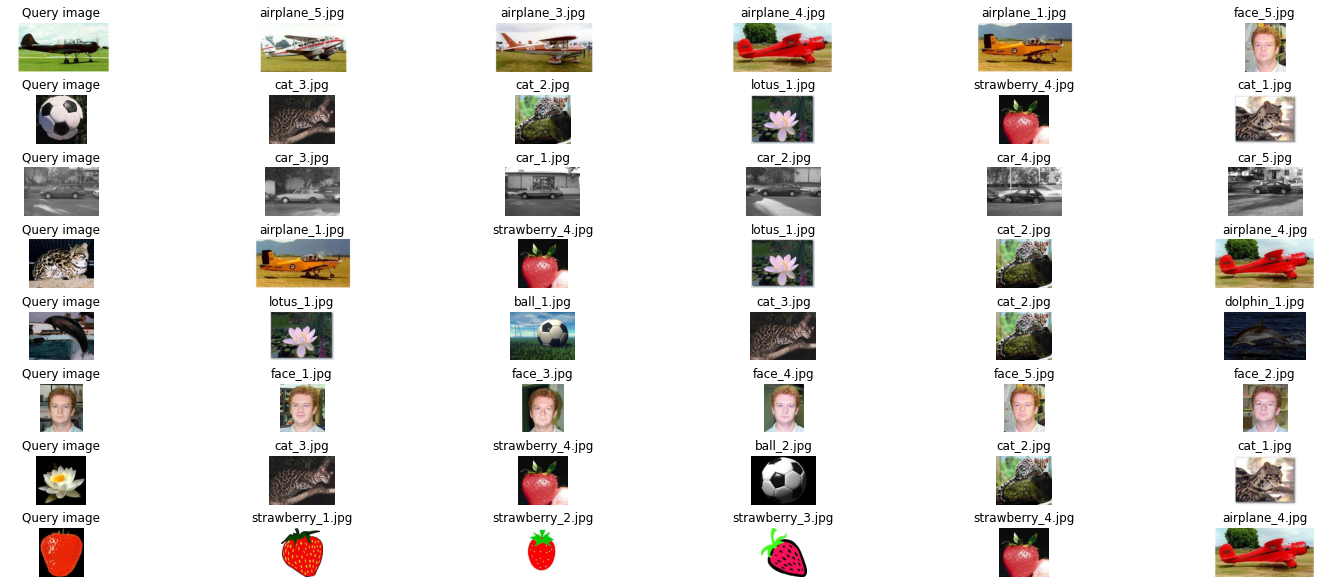

In [32]:
image = 'airplane_query.jpg'
all_images = True
method = 'histogram'
data_path = './data/part2/'
top_n = 5

a = main(image, data_path, method, top_n, all_images)

# Block Histogram

Query: airplane, Precision: 0.8 , Recall: 0.8, F1: 0.8000000000000002
Query: ball, Precision: 0.0 , Recall: 0.0, F1: 0
Query: car, Precision: 1.0 , Recall: 1.0, F1: 1.0
Query: cat, Precision: 0.2 , Recall: 0.2, F1: 0.20000000000000004
Query: dolphin, Precision: 0.2 , Recall: 0.2, F1: 0.20000000000000004
Query: face, Precision: 0.8 , Recall: 0.8, F1: 0.8000000000000002
Query: lotus, Precision: 0.0 , Recall: 0.0, F1: 0
Query: strawberry, Precision: 0.8 , Recall: 0.8, F1: 0.8000000000000002


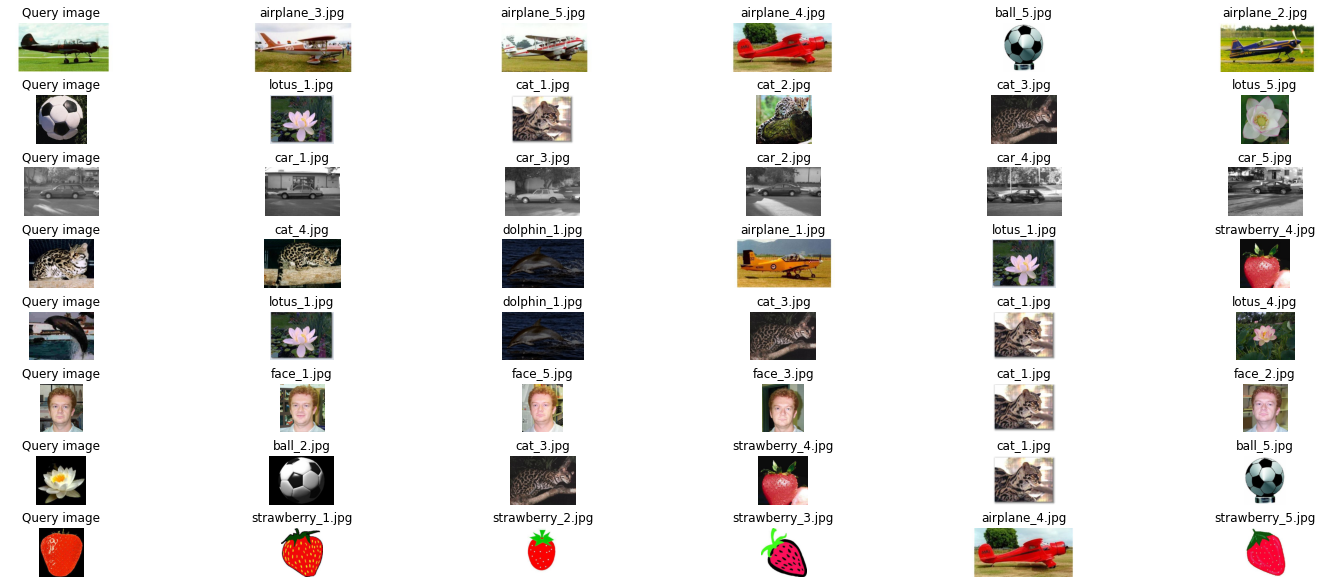

In [33]:
image = 'airplane_query.jpg'
all_images = True
method = 'block_histogram'
data_path = './data/part2/'
top_n = 5

a = main(image, data_path, method, top_n, all_images)

# Weighted Block Histogram

Query: airplane, Precision: 0.8 , Recall: 0.8, F1: 0.8000000000000002
Query: ball, Precision: 0.2 , Recall: 0.2, F1: 0.20000000000000004
Query: car, Precision: 1.0 , Recall: 1.0, F1: 1.0
Query: cat, Precision: 0.4 , Recall: 0.4, F1: 0.4000000000000001
Query: dolphin, Precision: 0.2 , Recall: 0.2, F1: 0.20000000000000004
Query: face, Precision: 0.6 , Recall: 0.6, F1: 0.6
Query: lotus, Precision: 0.0 , Recall: 0.0, F1: 0
Query: strawberry, Precision: 0.8 , Recall: 0.8, F1: 0.8000000000000002


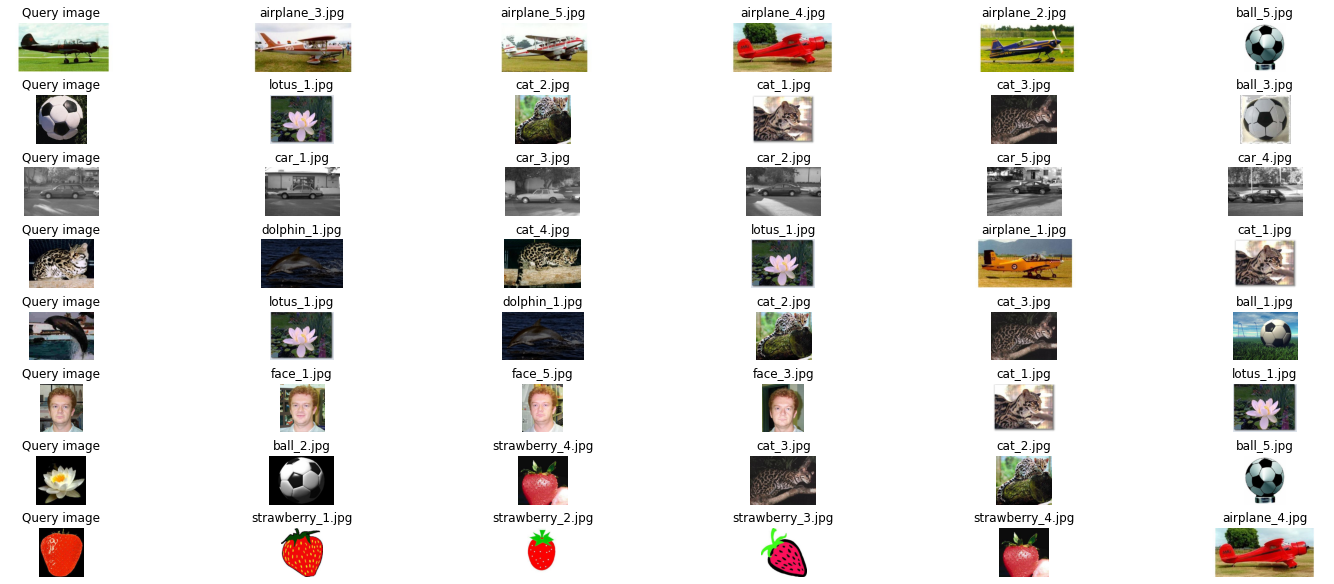

In [34]:
image = 'airplane_query.jpg'
all_images = True
method = 'weighted_block_histogram'
data_path = './data/part2/'
top_n = 5

a = main(image, data_path, method, top_n, all_images)